# _NY Times_ Crossword Difficulty by Day of the Week

What follows is my just-for-fun attempt to recreate the analysis of NY Times crossword puzzle difficulty vs weekday, as outlined in [Roy Leban's Puzzazz blog post](http://www.puzzazz.com/puzzle-difficulty-index).  Although we don't have access to Roy's data, his analysis can be approximated by scraping the puzzle solving times from [Bill Butler's NY Times crossword solutions website](http://www.nytcrossword.com).  

The functions below are designed to:
  * scrape the relevant data from Bill's website and write the data to .csv file
    * once this is completed, the function will skip the web scraping auto-load the data from file
  * generate histograms of puzzle difficulty by day of the week
  * fit Gaussian distributions to the histograms / examine them for Gaussianity
  * produce Q-Q plots and IQR plots to examine the data distribution
  * recreate Roy's puzzle difficulty plot using the scraped data
  
Everything should run smoothly from start to finish so long as you've installed the requisite Python libraries imported in the next cell:

In [1]:
% matplotlib inline

import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import os
import re
import urllib2
import csv
from bs4 import BeautifulSoup
import os
import pandas as pd
import scipy.stats 
import scipy.optimize

----
## The Data: Bill Butler's Crossword Puzzle Solving Times:

First we'll scrape the relevant data from Bill's website.  We'll save the data to `.csv` for safekeeping / for quick loading in the future:

In [2]:
def get_num_days(year, month):
    '''
    A function to determine the number of days in a given month
    for a given year.  This function is called when looping over
    the days within each month in the scrape_daily_weather function.
    Inputs: year and month as integers
    Output: number of days (int)
    '''
    leap_year = False
    if (year % 400 == 0) or ((year % 4 == 0) and (year % 100 != 0)):
        leap_year = True
    if month == 2:
        num_days = 28
        if leap_year:
            num_days = 29
    elif month in [4, 6, 9, 11]:
        num_days = 30
    else:
        num_days = 31
    return num_days

def get_solving_time(url):
    '''
    A function to search for Bill Butler's puzzle 'Completion Time' on the 
    web page for a daily NY Times crossword puzzle.  
     - Input: url for a daily crossword solution web page.
     - Output: puzzle solving_time in minutes.
    Includes error handling for variable formatting of Butler's reported
    solving times (e.g., '5m 23s'; '45m 10s!!!'; 'Didn't solve today's
    puzzle because I was watching HBO...'; etc.)
    '''
    try:
        page = urllib2.urlopen(url).read()
    except:
        return pl.nan
    soup = BeautifulSoup(page)
    try: # for pages after mid-2013:
        solving_time_string = soup.find('a', text='BILL BUTLER').parent.next_sibling
    except:
        try: # for pages before mid-2013:
            solving_time_string = soup.find('b', text=re.compile('Completion Time', re.I)).next_sibling
        except: # for the few pages that don't list a completion time:
            return pl.nan
    try:
        minutes_string, seconds_string = solving_time_string.split('m')
        minutes = minutes_string.split(' ')[-1]
        seconds = seconds_string.split('s')[0]
        solving_time = '%.1f' % (float(minutes) + float(seconds)/60.)
    except:
        solving_time = pl.nan
    return solving_time

def get_puzzle_solving_data_for_date(year, month, day):
    '''
    A function to scrape the date, weekday, and solving time for NYT crossword
    puzzles from Bill Butler's crossword solutions web site.
    '''
    # generate date stamp
    if month < 10:
        month = '0%s' % month
    if day < 10:
        day = '0%s' % day
    date_stamp = '%s-%s-%s' % (year, month, day)
    # determine which day of the week:
    weekday_dict = {0:'Mon', 1:'Tues', 2:'Wed', 3:'Thurs', 4:'Fri',
                    5:'Sat', 6:'Sun'}
    weekday = weekday_dict[pd.to_datetime(date_stamp).dayofweek]
    # scrape puzzle solving time from Bill Butler's blog:
    url = 'http://www.nytcrossword.com/%s/%s/%s%s-%s-new-york-times-crossword.html' % \
            (year, month, month, day, str(year)[2:])
    solving_time = get_solving_time(url)
    return date_stamp, weekday, solving_time
        
def get_data(years=range(2009,2018)):
    '''
    A function to generate a Pandas data frame of crossword solutions data and write it to
    a .csv file.  If the .csv file already exists, the function loads the data from file.
    '''
    data_filename = 'crossword_data.csv'
    if data_filename in os.listdir('.'):
        df = pd.read_csv(data_filename)
        return df
    df = pd.DataFrame(columns=['date', 'weekday', 'solving_time'])
    for year in years:
        for month in range(1,13):
            if year == 2017 and month > 6:
                break
            num_days = get_num_days(year, month)
            for day in range(1,num_days+1):
                date_stamp, weekday, solving_time = \
                    get_puzzle_solving_data_for_date(year, month, day)
                df = df.append({'date':date_stamp, 'weekday':weekday, 
                                'solving_time':solving_time}, ignore_index=True)
    df.to_csv(data_filename, sep=',', index=False)
    return df
    
df = get_data()
df.tail()

,date,weekday,solving_time
3098,2017-06-26,Mon,4.9
3099,2017-06-27,Tues,5.5
3100,2017-06-28,Wed,7.3
3101,2017-06-29,Thurs,11.2
3102,2017-06-30,Fri,11.7


----
## Analysis

In [3]:
solving_times = {}

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

for weekday in df['weekday'].unique():
    weekday_solving_times = df[df['weekday'] == weekday].solving_time
    weekday_solving_times = reject_outliers(weekday_solving_times)
    solving_times[weekday] = weekday_solving_times

### A first look at the data: Histograms for each day of the week, with medians indicated by vertical lines

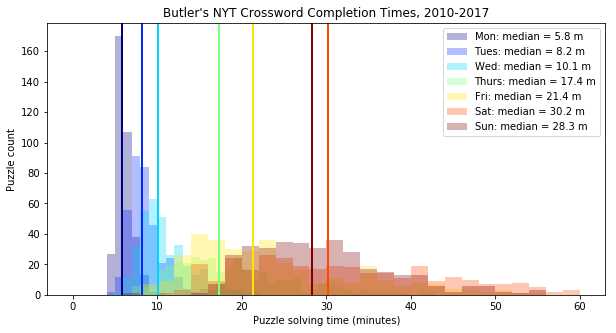

In [4]:
weekdays = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
colors = plt.cm.jet(np.linspace(0,1,7))

maxs, mins, medians = [], [], []

pl.figure(figsize=(10,5))
for weekday, color in zip(weekdays, colors):
    bin_width = 1
    if weekday in (['Fri', 'Sat', 'Sun']):
        bin_width = 2
    bins = np.arange(0, 60+bin_width, bin_width)
    maxs.append(np.max(solving_times[weekday]))
    mins.append(np.min(solving_times[weekday]))
    median = np.median(solving_times[weekday])
    medians.append(median)
    pl.hist(solving_times[weekday], bins=bins, alpha=0.3, 
            color=color, label='%s: median = %.1f m' % (weekday, median))
    pl.axvline(x=median, color=color, lw=2)
pl.xlabel('Puzzle solving time (minutes)')
pl.ylabel('Puzzle count')
pl.title('Butler\'s NYT Crossword Completion Times, 2010-2017')
pl.legend(fontsize=10)
pl.show()

maxs = pl.array(maxs)
mins = pl.array(mins)


Already we can see that the median puzzle difficulty increases from Monday through Saturday, but drops a bit on Sundays.  This is not unexpected; as [https://en.wikipedia.org/wiki/The_New_York_Times_crossword_puzzle](Wikipedia) tells us,

  * "The puzzle becomes increasingly difficult throughout the week, with the easiest puzzle on Monday and the most difficult puzzle on Saturday. __The larger Sunday crossword,__ which appears in The New York Times Magazine, is an icon in American culture; it __is typically intended to be as difficult as a Thursday puzzle.__"


### Recreating Roy Leban's Puzzazz Plot


[Roy Leban's Puzzazz blog post](http://www.puzzazz.com/puzzle-difficulty-index) contains an informative plot of puzzle difficulty as a function of day of the week.  It shows the overall average solving time (black line), normalized to a  such that the average Times Monday puzzle is fixed at 1.0.  Leban refers to this as a "difficulty index"; a puzzle with a difficulty index of 2.0 would be expected to take twice as long to complete as a Monday puzzle.) Leban also calculated ranges for "typical," "easy," and "hard" puzzles, based on clusterings of completion times. 

![](http://www.puzzazz.com/images/nyt-difficulty-by-day.png)

----

### How Gaussian Are the Puzzle Solving Times?

We don't have access to Roy's data set.  But we can try to recreate something similar using Bill Butler's solving times.  For this purpose we'll do two things:

  1. We'll **plot the total range** of Bill's solving times.
  2. We'll **fit a Gaussian distribution** to the solving times for each day of the week, and will use them to **plot the average solving time and a $\pm~1\sigma$ envelope.**  Here we assume that _if_ puzzle solving times follow a Gaussian distribution, then roughly 68% of solving times will fall within one standard deviation of the mean.

At the outset, note that the assumption in (2) is somewhat dubious.  It's entirely possible -- maybe even likely -- that the distributions for one or more weekdays aren't Gaussian.  This is especially so for days where puzzles tend to be more difficult, where we expect solving times to skew towards larger values.  As a sanity check, we'll do the following:

  * We'll pay close attention to the median value for each weekday.  In a normal distribution the mean and median should be the same.
  * Further below we'll also look at the **interquartilie range (IQR)** of the data sets, i.e., the range that covers the 1st to the middle 50% of the data $(Q_3~-~Q_1)$.
  * We'll also produce **Q-Q (quantile-quantile) plots** for each distribution to compare the data's quantiles with the quantiles expected for a normal distribution.   A Q-Q plot is a scatter plot of the data set's quantiles against the quantiles of a known theoretical distribution -- in this case, the normal distribution.  If the distributions are similar the Q-Q plot will follow a straight line.

In [5]:
def fit_gaussian(xdata, ydata):
    '''
    A function to perform a least-squares fit to a Gaussian distribution.
    '''
    fitfunc = lambda p, x: p[0] * np.exp(-1.*(p[1] - x)**2 / (2.*p[2]**2.))
    errfunc = lambda p, x, y: fitfunc(p, x) - y
    # Initial guesses:
    p = [pl.nan, pl.nan, pl.nan]
    p[0] = max(ydata)
    p[1] = xdata[np.where(ydata == max(ydata))[0]][0]
    p[2] = xdata[1] - xdata[0]    # Assume a wide distribution to start
    p1, success = scipy.optimize.leastsq(errfunc, p[:], args=(xdata, ydata))
    return p1[0],  p1[1], abs(p1[2])#, p[3]

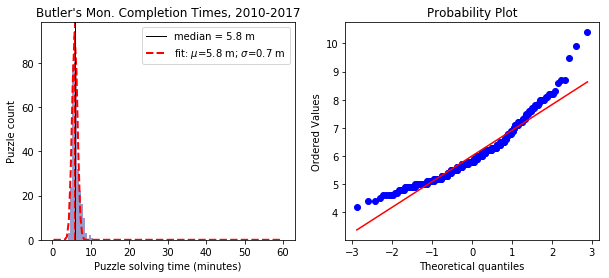

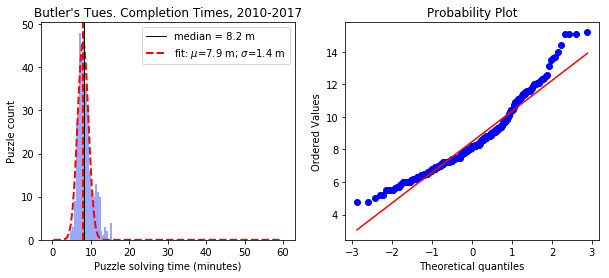

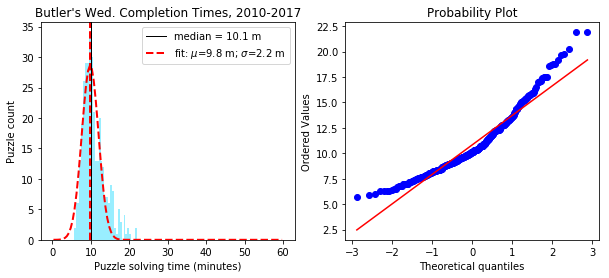

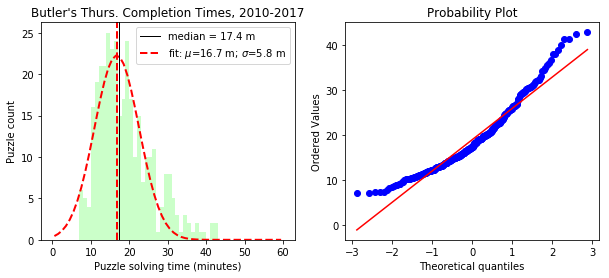

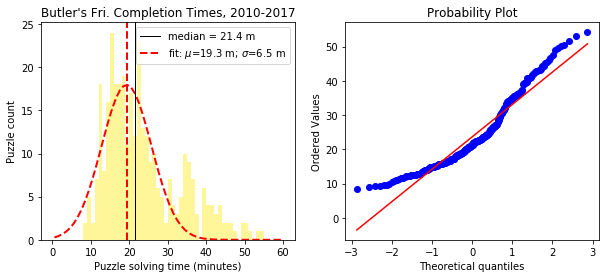

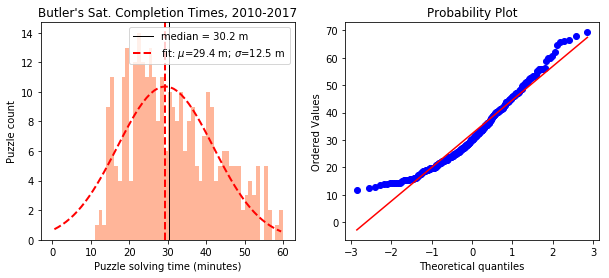

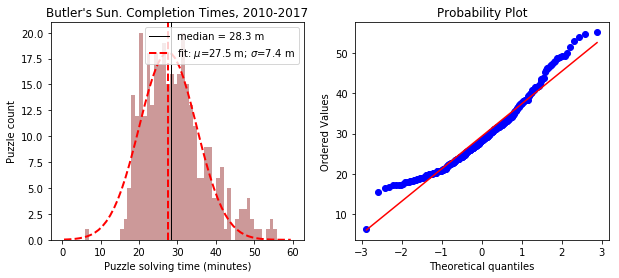

In [6]:
mus, sigmas = [], []

for weekday, color in zip(weekdays, colors):
    bin_width = 0.5
    if weekday in (['Thurs', 'Fri', 'Sat', 'Sun']):
        bin_width = 1
    bins = np.arange(0, 60+bin_width, bin_width)
        
    pl.figure(figsize=(10,4))
    pl.subplot(121)
    bin_counts, bin_edges, patches = pl.hist(solving_times[weekday], bins=bins, 
                                             color=color, alpha=0.4)
    bin_centers = (bins + 0.5*(bins[1] - bins[0]))[:-1]
    amplitude, mu, sigma = fit_gaussian(bin_centers, bin_counts)
    mus.append(mu)
    sigmas.append(sigma)
    
    fit = amplitude * np.exp(-1 * (bin_centers - mu)**2 / (2*sigma** 2)) 
    pl.plot(bin_centers, fit, color='r', linestyle='--', lw=2)
    pl.axvline(x=mu, color='r', linestyle='--', lw=2)
    
    median = '%.1f' % np.median(solving_times[weekday])
    pl.axvline(x=float(median.split(' ')[0]), color='k', lw=1, 
               label='median = %s m' % median)
    pl.plot([], [], color='r', linestyle='--', lw=2, \
            label='fit: $\mu$=%.1f m; $\sigma$=%.1f m' % (mu, sigma))
    pl.xlabel('Puzzle solving time (minutes)')
    pl.ylabel('Puzzle count')
    pl.title('Butler\'s %s. Completion Times, 2010-2017' % weekday)
    pl.legend(loc='best', fontsize=10)
    
    pl.subplot(122)
    scipy.stats.probplot(solving_times[weekday], dist='norm', plot=pl)
    pl.show()

mus = pl.array(mus)
sigmas = pl.array(sigmas)

As expected, the distributions aren't very Gaussian; the solving times skew rightward, and also have heavy/lopsided tails.  

What sort of plot would we see if we assumed -- _incorrectly_ -- that the solving times are normally distributed, with the exception of a few outliers?

### The Wrong Plot: 

Here's what the plot looks like if we naively assume the solving times are essentially normally distributed, and plot a +/- $1\sigma$ range in blue.  For reference I've also plotted the full range of the solving times in yellow:

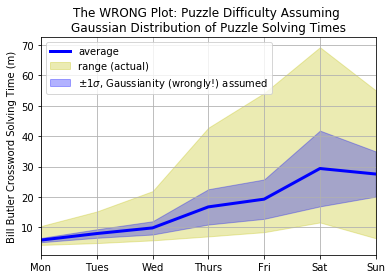

In [7]:
fig, ax = pl.subplots()
pl.fill_between(range(len(weekdays)), mins, maxs, color='y', alpha=0.3, 
                label='range (actual)')
pl.plot(range(len(weekdays)), mus, 'b-', lw=3, label='average')
pl.fill_between(range(len(weekdays)), mus-sigmas, mus+sigmas, color='b', 
                alpha=0.3, label='$\pm$1$\sigma$, Gaussianity (wrongly!) assumed')
pl.xlim(0, len(weekdays)-1)
ax.set_xticklabels(weekdays)
pl.ylabel('Bill Butler Crossword Solving Time (m)')
pl.legend(loc='upper left')
pl.title('The WRONG Plot: Puzzle Difficulty Assuming \nGaussian Distribution of Puzzle Solving Times')
pl.grid()
pl.show()

## Box Plots / IQRs

Box plots provide a more useful/representative plot for data sets with non-Gaussian distributions:
 * __Boxes:__ the "box" on each boxplot extends over the "interquartile range" (IQR), i.e., from the 1st to the 3rd quartile of the data.  In other words, the boxes extend over the range containing the 25th to the 75th percentile of the data.
 * __Median lines:__ horizonal lines showing the median of the data (i.e., the 2nd quartile).
 * __Whiskers__: vertical lines extending to _the most extreme data points within 1.5 * IQR_. The ends of the whiskers are marked by short horizonal "caps."
 * __Outliers (fliers):__ points showing outlier data samples that lie beyond the extent of the whiskers.

Note that the overall behavior of the box plots below generally follows that of the Gaussian fits plotted above: the puzzle difficulty (as measured by Bill's solving time) trends upward from Monday through Saturday, then dips a bit on Sunday.

/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


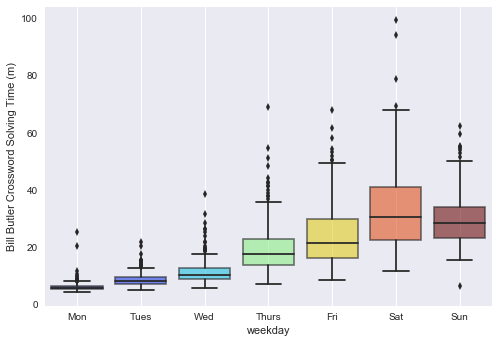

In [8]:
import seaborn

fig, ax = pl.subplots()
ax = seaborn.boxplot('weekday', 'solving_time', data=df, order=weekdays, palette=colors)
plt.setp(ax.artists, alpha=0.6)
pl.ylabel('Bill Butler Crossword Solving Time (m)')
pl.legend(loc='best')
pl.grid()
pl.show()

## Approximating Roy's Puzzle Difficulty Index Plot:

Box plots are handy and informative if you're used to reading them.  But the average reader may find them confusing.  Instead let's create a shaded plot in the style of the Puzzazz graph above.  I'll even borrow their color scheme, with apologies to Roy:

In [9]:
quartiles = np.empty((7,0)).tolist()

for weekday in weekdays:
    solving_times = df[df['weekday']==weekday]['solving_time']
    solving_times = solving_times[~pl.isnan(solving_times)]
    weekday_quartiles = np.percentile(solving_times, [1,10,25,50,75,90,99])
    for i in range(len(weekday_quartiles)):
        quartiles[i].append(weekday_quartiles[i])

q1s, q10s, q25s, medians, q75s, q90s, q99s = [quartiles[i] for i in range(len(quartiles))]

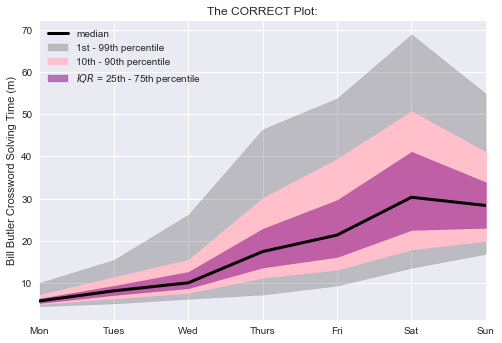

In [10]:
fig, ax = pl.subplots()
pl.fill_between(range(len(weekdays)), q1s, q99s, color='k', alpha=0.2, 
                label='1st - 99th percentile')
pl.fill_between(range(len(weekdays)), q10s, q90s, color='pink', 
                alpha=1.0, label='10th - 90th percentile')
pl.fill_between(range(len(weekdays)), q25s, q75s, color='purple', 
                alpha=0.5, label='$IQR$ = 25th - 75th percentile')
pl.plot(range(len(weekdays)), medians, 'k-', lw=3, label='median')
pl.xlim(0, len(weekdays)-1)
ax.set_xticklabels(weekdays)
pl.ylabel('Bill Butler Crossword Solving Time (m)')
pl.legend(loc='upper left')
pl.title('The CORRECT Plot:')
pl.show()

This is looking better.  Finally, let's normalize the plot by setting the median solving time for the Monday puzzle a "Butler difficulty index" equal to 1.0:

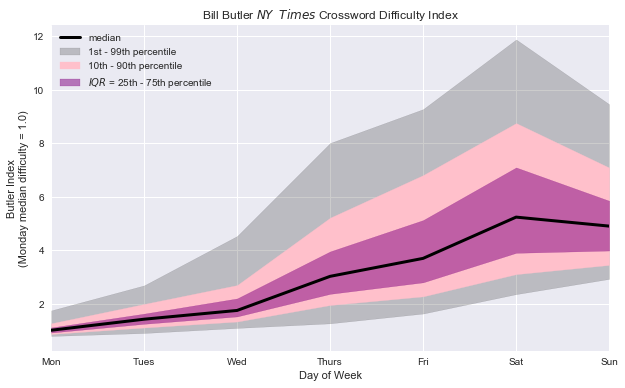

In [11]:
fig, ax = pl.subplots(figsize=(10,6))
pl.fill_between(range(len(weekdays)), q1s/medians[0], q99s/medians[0], 
                color='k', alpha=0.2, label='1st - 99th percentile')
pl.fill_between(range(len(weekdays)), q10s/medians[0], q90s/medians[0], 
                color='pink', alpha=1.0, label='10th - 90th percentile')
pl.fill_between(range(len(weekdays)), q25s/medians[0], q75s/medians[0], 
                color='purple', alpha=0.5, label='$IQR$ = 25th - 75th percentile')
pl.plot(range(len(weekdays)), medians/medians[0], 'k-', lw=3, label='median')
pl.xlim(0, len(weekdays)-1)
ax.set_xticklabels(weekdays)
pl.title('Bill Butler $NY$  $Times$ Crossword Difficulty Index')
pl.ylabel('Butler Index\n(Monday median difficulty = 1.0)')
pl.xlabel('Day of Week')
pl.legend(loc='upper left')
pl.show()

Et voila: an approximation of Roy's puzzle difficulty index plot, made from scratch.